In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dolfin as df

In [2]:
def to_homogeneous(A, b):
    T = np.zeros((A.shape[0]+1, A.shape[1]+1))
    T[:-1, :-1] = A
    T[:-1, -1] = b
    T[-1, -1] = 1.0
    return T

def apply_transform(coords, T):
    A, b = T[:-1, :-1], T[:-1, -1]
    return coords.dot(A.T) + b


def create_image(x0, x1, H, W):
    """2D-specific."""
    x = np.linspace(x0[0], x1[0], W) 
    y = np.linspace(x0[1], x1[1], H)
    X, Y = np.meshgrid(x, y)
    return ((X-0.5)**2 + 0.5 * Y**2 )


# def cell_midpoints(mesh):
#     dim = mesh.geometric_dimension()
#     return np.array([cell.midpoint()[:] for cell in df.cells(mesh)])[:, :dim]


# def dof_coordinates(space):
#     return space.tabulate_dof_coordinates()


# def coordinates_to_index(coords, T):
#     ij = apply_transform(coords, T)
#     return np.floor(ij).astype(int)


# def bounding_box(domain):
#     x0 = np.array([domain.coordinates()[:, i].min() for i in range(domain.geometric_dimension())])
#     x1 = np.array([domain.coordinates()[:, i].max() for i in range(domain.geometric_dimension())])
#     return np.array([x0, x1])

def bounding_box(domain):
    p0 = np.array([domain.coordinates()[:, i].min() for i in range(domain.geometric_dimension())])
    p1 = np.array([domain.coordinates()[:, i].max() for i in range(domain.geometric_dimension())])
    return BoundingBox(p0, p1)

def in_domain(domain: df.Mesh, *args) -> bool:
    tree = domain.bounding_box_tree()
    entity = tree.compute_first_entity_collision(df.Point(*args))
    return entity < domain.num_cells()


def function_to_image(u, H, W, T):
    I_new = np.zeros((H, W))
    indices = [(i, j) for i in range(H) for j in range(W)]
    coords = apply_transform(np.array(indices).astype(float), T)
    for idx, xij in zip(indices, coords):
        I_new[*idx] = uh(*xij) if in_domain(uh.function_space().mesh(), *xij) else 0.0
    return I_new


def image_to_function(im, space, affine):
    xy = dof_coordinates(space)
    idx = coordinates_to_index(xy, np.linalg.inv(T)).T
    D = df.Function(space)
    D.vector()[:] = im[*idx]
    return D

from dataclasses import dataclass

@dataclass
class BoundingBox:
    p0: np.ndarray
    p1: np.ndarray

def xy2pix(bbox: BoundingBox, image_shape: np.ndarray) -> np.ndarray:
    x0 = bbox.p0[0]
    x1 = bbox.p1[0]
    y0 = bbox.p0[1]
    y1 = bbox.p1[1]
    C = np.array([
        [x0, y0, 1.0],
        [x0, y1, 1.0],
        [x1, y1, 1.0]
    ])
    H, W = image_shape
    J = np.array([
        [  H, 0.0, 1.0],
        [0.0, 0.0, 1.0],
        [ 0.0, W , 1.0]
    ])
    return np.linalg.solve(C, J).T

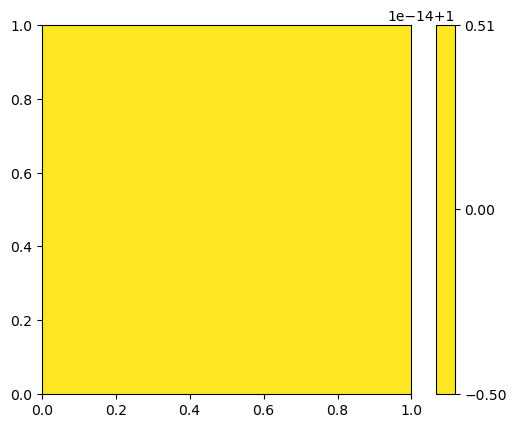

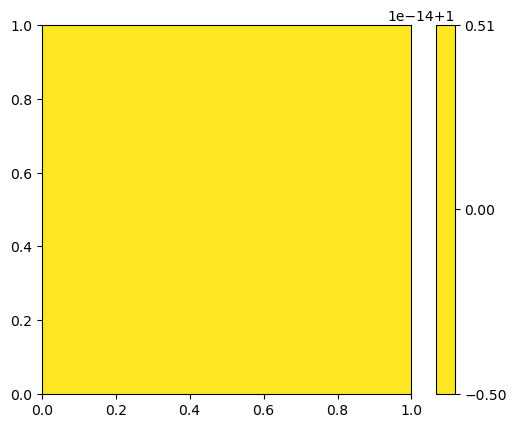

In [22]:
mesh = df.UnitSquareMesh(1, 1)
V = df.FunctionSpace(mesh, "CG", 1)
u = df.Function(V)

u2 = u.copy()
u2.vector()[:] = np.ones(4)

c = df.plot(u, vmin=0, vmax=1)
plt.colorbar(c)
plt.show()

c = df.plot(u2, vmin=0, vmax=1)
plt.colorbar(c)
plt.show()

2.75

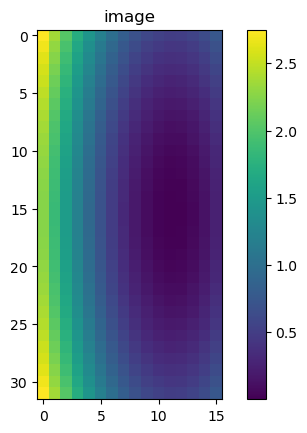

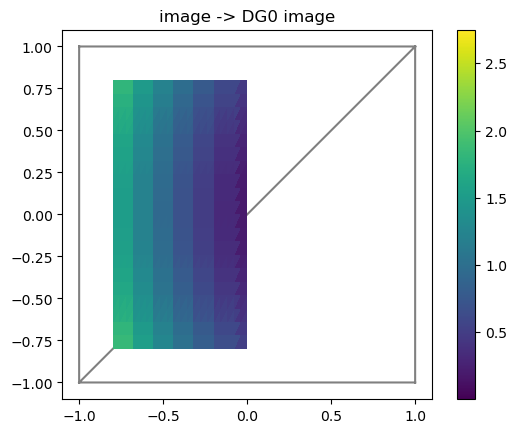

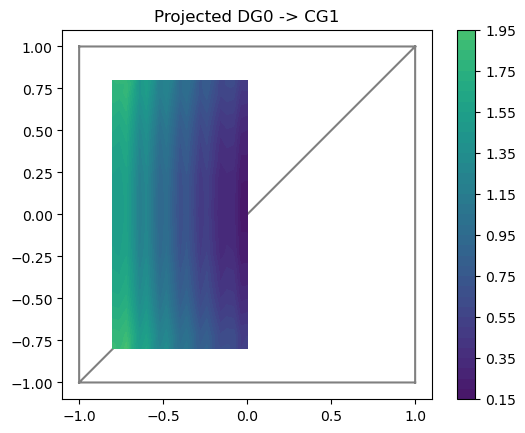

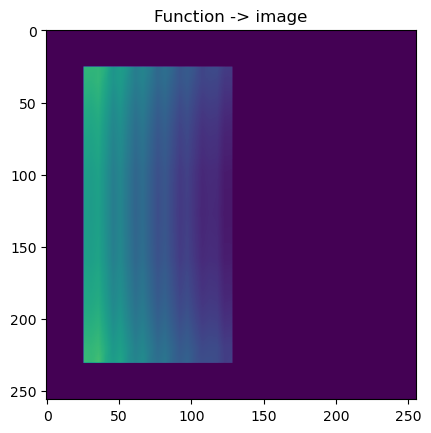

In [17]:
outer_domain = df.RectangleMesh(df.Point((-1, -1.)), df.Point(1.0, 1.0), 1, 1)
bbox = BoundingBox(
    np.array([-1.0, -1.0]),
    np.array([ 1.0,  1.0])
)
H, W = 32, 16
nx, ny = 20, 20

im = create_image(bbox.p0, bbox.p1, H, W)
T = xy2pix(bbox, im.shape)
Tinv = np.linalg.inv(T)

omega = df.RectangleMesh(df.Point((-0.8, -0.8)), df.Point((0.0, 0.8)), nx, ny)
DG0 = df.FunctionSpace(omega, "DG", 0)
xy = DG0.tabulate_dof_coordinates()
idx = apply_transform(xy, T)
idx = np.rint(idx).astype(int)
D = df.Function(DG0)
D.vector()[:] = im[*idx.T]


c = plt.imshow(im)
plt.colorbar()
plt.title("image")
plt.show()

df.plot(outer_domain)
c = df.plot(D, vmin=im.min(), vmax=im.max())
plt.colorbar(c)
plt.title("image -> DG0 image")
plt.show()

CG1 = df.FunctionSpace(omega, "CG", 1)
uh = df.project(D, CG1)
df.plot(outer_domain)
c = df.plot(uh, vmin=im.min(), vmax=im.max())
plt.colorbar(c)
plt.title("Projected DG0 -> CG1")
plt.show()

newshape = (256, 256)
T = xy2pix(bbox, newshape)
Tinv = np.linalg.inv(T)
im_new = function_to_image(uh, *newshape, Tinv)

plt.imshow(im_new, vmin=im.min(), vmax=im.max())
plt.title("Function -> image")
plt.show()

In [13]:
I = np.arange(H)
J = np.arange(W)
I, J = np.meshgrid(I, J)
index_grid = np.array([(i, j) for i in range(H) for j in range(W)])
Z = np.array([[im[i, j] for i in np.arange(H)] for j in np.arange(W)])

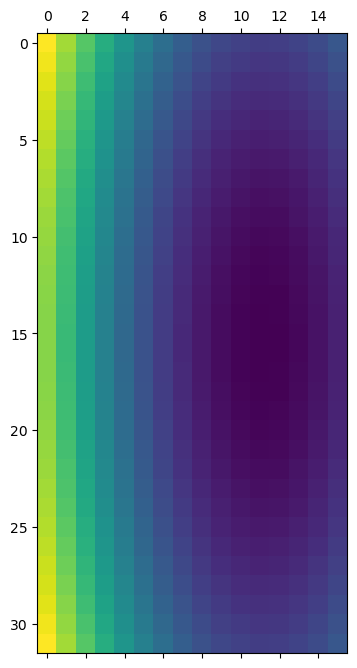

In [14]:
plt.matshow(im)

In [ ]:
# plt.contourf(I, J, Z, alpha=0.6)
plt.scatter(*index_grid.T)

In [ ]:
def plot_image_coord(im, *args ,**kwargs):
    H, W = im.shape
    ax = plt.gca()
    I = np.arange(H)
    J = np.arange(W)
    I, J = np.meshgrid(I, J)
    Z = np.array([[im[i, j] for i in np.arange(H)] for j in np.arange(W)])
    plt.contourf(I, J, Z, *args, **kwargs)
    return Z

In [ ]:
outer_domain = df.RectangleMesh(df.Point((-1, -1.)), df.Point(1.0, 1.0), 1, 1)
bbox = BoundingBox(
    np.array([-1.0, -1.0]),
    np.array([ 1.0,  1.0])
)
H, W = 32, 16
nx, ny = 20, 20


im = create_image(bbox.p0, bbox.p1, H, W)
T = xyz2pix(bbox, im.shape)
Tinv = np.linalg.inv(T)

shifted = df.Mesh(outer_domain)
shifted.coordinates()[:] = apply_transform(shifted.coordinates()[:], T)
DG0_outer = df.FunctionSpace(outer_domain, "DG", 0)
xy_outer = DG0_outer.tabulate_dof_coordinates()

om_shifted = df.Mesh(omega)
om_shifted.coordinates()[:] = apply_transform(om_shifted.coordinates()[:], T)
DG0_inner = df.FunctionSpace(omega, "DG", 0)
xy_inner = DG0_inner.tabulate_dof_coordinates()


plot_image_coord(im, alpha=0.5)
df.plot(shifted, color="r")
df.plot(outer_domain, color="r")
df.plot(omega, color="k", lw=0.1)
df.plot(om_shifted, color="k", lw=0.2)
df.plot(outer_domain, color="r")
plt.scatter(*(apply_transform(xy_outer, T)).T)
plt.scatter(*(apply_transform(xy_inner, T)).T, s=0.3)
plt.show()

In [ ]:
index_grid = np.array([
    (i, j) for i in range(H) for j in range(W)
])

idx_coords = apply_transform(index_grid, Tinv)
xy_ = apply_transform(idx, Tinv)

plt.scatter(*idx_coords.T)
plt.scatter(*xy_.T)
df.plot(outer_domain, color="r")
df.plot(omega, color="k", lw=0.6)
plt.show()